# TTE R TO PYTHON

## 1. Setup 

A sequence of target trials analysis starts by specifying which estimand will be used:

```R
trial_pp  <- trial_sequence(estimand = "PP")  # Per-protocol

trial_itt <- trial_sequence(estimand = "ITT") # Intention-to-treat
``` 

Additionally it is useful to create a directory to save files for later inspection.

```R
trial_pp_dir  <- file.path(tempdir(), "trial_pp")
dir.create(trial_pp_dir)

trial_itt_dir <- file.path(tempdir(), "trial_itt")
dir.create(trial_itt_dir)
``` 

### Python Equivalent:

In [2]:
import os

# Create directories
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

# Setup trial sequences as dictionaries
trial_pp = {"estimand": "PP", "dir": trial_pp_dir}
trial_itt = {"estimand": "ITT", "dir": trial_itt_dir}

Used dictionaries to store trial settings and os to create directories. 
Since there's no direct equivalent to trial_sequence(), so I mimiced the structure at 

<div class="alert alert-block alert-warning">
os.makedirs(..., exist_ok=True) ensures directories are created without raising an error if they already exist. <br>

The trial objects (trial_pp, trial_itt) are dictionaries that will hold all trial-related data and settings.
</div>


___


## 2. Data Preparation

Next the user must specify the observational input data that will be used for the target trial emulation. Here we need to specify which columns contain which values and how they should be used.

``` R
data("data_censored") # dummy data in the package
head(data_censored)

trial_pp <- trial_pp |>
  set_data(
    data      = data_censored,
    id        = "id",
    period    = "period",
    treatment = "treatment",
    outcome   = "outcome",
    eligible  = "eligible"
  )

# ITT
# Function style without pipes
trial_itt <- set_data( 
  trial_itt,
  data      = data_censored,
  id        = "id",
  period    = "period",
  treatment = "treatment",
  outcome   = "outcome",
  eligible  = "eligible"
)

trial_itt

### Python Equivalent:

In [ ]:
import pandas as pd

# Load data (assuming it's saved as a CSV)
data_censored = pd.read_csv("data_censored.csv")

# Define column mappings
columns = {
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}

# Assign data and columns to trials
trial_pp["data"] = data_censored.copy()
trial_pp["columns"] = columns

trial_itt["data"] = data_censored.copy()
trial_itt["columns"] = columns

# Display the first few rows (equivalent to head())
print(data_censored.head())

Loaded the data from the CSV file and store it in the trial dictionaries. 

Used ```python pd.read_csv()``` instead of ```R data("data_censored")```

In [26]:
import os
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
import pickle

# Setup (Sections 1 and 2)
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

trial_pp = {"estimand": "PP", "dir": trial_pp_dir}
trial_itt = {"estimand": "ITT", "dir": trial_itt_dir}

data_censored = pd.read_csv("data_censored.csv")
trial_pp["data"] = data_censored.copy()
trial_pp["columns"] = {"id": "id", "period": "period", "treatment": "treatment", "outcome": "outcome", "eligible": "eligible"}
trial_itt["data"] = data_censored.copy()
trial_itt["columns"] = trial_pp["columns"]

# --- Section 3: Weight Models and Censoring ---
def set_weight_models(trial, weight_type, censor_event=None, numerator_vars=None, denominator_vars=None, pool_models="none", save_path=None):
    # Store configuration without fitting models yet
    trial[f"{weight_type}_config"] = {
        "censor_event": censor_event,
        "numerator_vars": numerator_vars,
        "denominator_vars": denominator_vars,
        "pool_models": pool_models,
        "save_path": save_path,
        "fitted": False
    }

def show_weight_config(trial, weight_type):
    config = trial.get(f"{weight_type}_config", {})
    if not config:
        return
    print(f"##  - Numerator formula: 1 - censored ~ {' + '.join(config['numerator_vars']) if weight_type == 'censor' else 'treatment ~ ' + ' + '.join(config['numerator_vars'])}")
    print(f"##  - Denominator formula: 1 - censored ~ {' + '.join(config['denominator_vars']) if weight_type == 'censor' else 'treatment ~ ' + ' + '.join(config['denominator_vars'])}")
    if weight_type == "censor" and config["pool_models"] == "numerator":
        print("##  - Numerator model is pooled across treatment arms. Denominator model is not pooled.")
    print("##  - Model fitter type: te_stats_glm_logit")
    print("##  - Weight models not fitted. Use calculate_weights()")

# Set and show switch weight models (PP only)
set_weight_models(
    trial_pp,
    weight_type="switch",
    numerator_vars=["age"],
    denominator_vars=["age", "x1", "x3"],
    save_path=os.path.join(trial_pp["dir"], "switch_models")
)
print("Switch Weight Config for trial_pp:")
show_weight_config(trial_pp, "switch")

# Set and show censor weight models (PP)
set_weight_models(
    trial_pp,
    weight_type="censor",
    censor_event="censored",
    numerator_vars=["x2"],
    denominator_vars=["x2", "x1"],
    pool_models="none",
    save_path=os.path.join(trial_pp["dir"], "switch_models")
)
print("\nCensor Weight Config for trial_pp:")
show_weight_config(trial_pp, "censor")

# Set and show censor weight models (ITT)
set_weight_models(
    trial_itt,
    weight_type="censor",
    censor_event="censored",
    numerator_vars=["x2"],
    denominator_vars=["x2", "x1"],
    pool_models="numerator",
    save_path=os.path.join(trial_itt["dir"], "switch_models")
)
print("\nCensor Weight Config for trial_itt:")
show_weight_config(trial_itt, "censor")

Switch Weight Config for trial_pp:
##  - Numerator formula: 1 - censored ~ treatment ~ age
##  - Denominator formula: 1 - censored ~ treatment ~ age + x1 + x3
##  - Model fitter type: te_stats_glm_logit
##  - Weight models not fitted. Use calculate_weights()

Censor Weight Config for trial_pp:
##  - Numerator formula: 1 - censored ~ x2
##  - Denominator formula: 1 - censored ~ x2 + x1
##  - Model fitter type: te_stats_glm_logit
##  - Weight models not fitted. Use calculate_weights()

Censor Weight Config for trial_itt:
##  - Numerator formula: 1 - censored ~ x2
##  - Denominator formula: 1 - censored ~ x2 + x1
##  - Numerator model is pooled across treatment arms. Denominator model is not pooled.
##  - Model fitter type: te_stats_glm_logit
##  - Weight models not fitted. Use calculate_weights()


In [27]:
# Setup (Sections 1-2)
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

trial_pp = {"estimand": "PP", "dir": trial_pp_dir}
trial_itt = {"estimand": "ITT", "dir": trial_itt_dir}

data_censored = pd.read_csv("data_censored.csv")
trial_pp["data"] = data_censored.copy()
trial_pp["columns"] = {"id": "id", "period": "period", "treatment": "treatment", "outcome": "outcome", "eligible": "eligible"}
trial_itt["data"] = data_censored.copy()
trial_itt["columns"] = trial_pp["columns"]

# Section 3 (unchanged)
def set_weight_models(trial, weight_type, censor_event=None, numerator_vars=None, denominator_vars=None, pool_models="none", save_path=None):
    trial[f"{weight_type}_config"] = {
        "censor_event": censor_event,
        "numerator_vars": numerator_vars,
        "denominator_vars": denominator_vars,
        "pool_models": pool_models,
        "save_path": save_path,
        "fitted": False
    }

def show_weight_config(trial, weight_type):
    config = trial.get(f"{weight_type}_config", {})
    if not config:
        return
    print(f"##  - Numerator formula: 1 - censored ~ {' + '.join(config['numerator_vars']) if weight_type == 'censor' else 'treatment ~ ' + ' + '.join(config['numerator_vars'])}")
    print(f"##  - Denominator formula: 1 - censored ~ {' + '.join(config['denominator_vars']) if weight_type == 'censor' else 'treatment ~ ' + ' + '.join(config['denominator_vars'])}")
    if weight_type == "censor" and config["pool_models"] == "numerator":
        print("##  - Numerator model is pooled across treatment arms. Denominator model is not pooled.")
    print("##  - Model fitter type: te_stats_glm_logit")
    print("##  - Weight models not fitted. Use calculate_weights()")

set_weight_models(trial_pp, "switch", numerator_vars=["age"], denominator_vars=["age", "x1", "x3"], save_path=os.path.join(trial_pp["dir"], "switch_models"))
set_weight_models(trial_pp, "censor", censor_event="censored", numerator_vars=["x2"], denominator_vars=["x2", "x1"], pool_models="none", save_path=os.path.join(trial_pp["dir"], "switch_models"))
set_weight_models(trial_itt, "censor", censor_event="censored", numerator_vars=["x2"], denominator_vars=["x2", "x1"], pool_models="numerator", save_path=os.path.join(trial_itt["dir"], "switch_models"))

# Section 4 (updated with statsmodels)
def fit_weight_models(trial, weight_type):
    config = trial[f"{weight_type}_config"]
    data = trial["data"].copy()
    models = {}
    
    if weight_type == "switch":
        data['prev_treatment'] = data.groupby('id')['treatment'].shift(1).fillna(0)
        groups = data.groupby('prev_treatment')
        outcome = 'treatment'
        formula_num = f"{outcome} ~ {' + '.join(config['numerator_vars'])}"
        formula_den = f"{outcome} ~ {' + '.join(config['denominator_vars'])}"
    elif weight_type == "censor":
        outcome = config["censor_event"]
        data[outcome] = 1 - data[outcome]  # 1 - censored
        groups = {"pooled": data} if config["pool_models"] == "numerator" else data.groupby('treatment')
        formula_num = f"{outcome} ~ {' + '.join(config['numerator_vars'])}"
        formula_den = f"{outcome} ~ {' + '.join(config['denominator_vars'])}"
    
    iterator = groups.items() if isinstance(groups, dict) else groups
    for group_name, group_data in iterator:
        model_num = smf.glm(formula_num, data=group_data, family=sm.families.Binomial()).fit()
        model_den = smf.glm(formula_den, data=group_data, family=sm.families.Binomial()).fit()
        models[group_name] = {"numerator": model_num, "denominator": model_den}
        if config["save_path"]:
            os.makedirs(config["save_path"], exist_ok=True)
            with open(os.path.join(config["save_path"], f"model_{weight_type}_{group_name}_num.pkl"), 'wb') as f:
                pickle.dump(model_num, f)
            with open(os.path.join(config["save_path"], f"model_{weight_type}_{group_name}_den.pkl"), 'wb') as f:
                pickle.dump(model_den, f)
    
    trial[f"{weight_type}_models"] = models
    config["fitted"] = True

def calculate_weights(trial, weight_type):
    if not trial[f"{weight_type}_config"]["fitted"]:
        fit_weight_models(trial, weight_type)
    
    data = trial["data"].copy()
    models = trial[f"{weight_type}_models"]
    
    if weight_type == "switch" and 'prev_treatment' not in data.columns:
        data['prev_treatment'] = data.groupby('id')['treatment'].shift(1).fillna(0)
    
    iterator = models.items()
    for group_name, model_dict in iterator:
        group_data = data[data['prev_treatment' if weight_type == "switch" else 'treatment'] == group_name] if group_name != "pooled" else data
        idx = group_data.index
        prob_num = model_dict["numerator"].predict(group_data)
        prob_den = model_dict["denominator"].predict(group_data)
        weight = prob_num / prob_den if weight_type != "switch" or group_name == 1 else (1 - prob_num) / (1 - prob_den)
        data.loc[idx, f"{weight_type}_weight"] = weight
    
    trial["data"] = data

calculate_weights(trial_pp, "switch")
calculate_weights(trial_pp, "censor")
calculate_weights(trial_itt, "censor")

# New: Show Weight Models
def show_weight_models(trial):
    for weight_type in ["switch", "censor"]:
        if f"{weight_type}_models" not in trial:
            continue
        print(f"## Weight Models for {'Treatment Switching' if weight_type == 'switch' else 'Informative Censoring'}")
        print("## ---------------------------------------\n")
        models = trial[f"{weight_type}_models"]
        for group_name, model_dict in models.items():
            for model_type, model in model_dict.items():
                desc = f"P({'treatment' if weight_type == 'switch' else 'censor_event'} = {'1' if weight_type == 'switch' else '0'} | X, previous treatment = {group_name})" if weight_type == "switch" else \
                       f"P(censor_event = 0 | X{' pooled' if group_name == 'pooled' else f', treatment = {group_name}'})"
                print(f"## [[{model_type[0]}{group_name}]]")
                print(f"## Model: {desc} for {model_type}")
                print("##  ")
                print("##  term        estimate   std.error statistic p.value")
                coef_table = model.summary2().tables[1]
                for idx, row in coef_table.iterrows():
                    print(f"##  {idx:<12} {row['Coef.']:.7f} {row['Std.Err.']:.7f} {row['z']:.6f} {row['P>|z|']:.6e}")
                print(f"##  ")
                print(f"##  null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
                print(f"##  {model.null_deviance:.4f}      {model.df_model + model.df_resid:.0f}     {model.llf:.4f} {model.aic:.4f} {model.bic:.4f} {model.deviance:.4f} {model.df_resid:.0f}         {model.nobs:.0f}")
                print("##  ")
                
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Display results
print("Weight Models for trial_itt:")
show_weight_models(trial_itt)
print("\nWeight Models for trial_pp:")
show_weight_models(trial_pp)

Weight Models for trial_itt:
## Weight Models for Informative Censoring
## ---------------------------------------

## [[npooled]]
## Model: P(censor_event = 0 | X pooled) for numerator
##  
##  term        estimate   std.error statistic p.value
##  Intercept    2.4480907 0.1405747 17.414876 6.362614e-68
##  x2           -0.4486482 0.1368779 -3.277724 1.046476e-03
##  
##  null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
##  404.2156      724     -196.7002 397.4004 -4368.4017 393.4004 723         725
##  
## [[dpooled]]
## Model: P(censor_event = 0 | X pooled) for denominator
##  
##  term        estimate   std.error statistic p.value
##  Intercept    2.2058753 0.1653764 13.338511 1.381926e-40
##  x2           -0.4706448 0.1374972 -3.422940 6.194764e-04
##  x1           0.7019476 0.3072639 2.284511 2.234153e-02
##  
##  null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
##  404.2156      724     -193.8831 393.7661 -4367.4498 387.7661 

---

In [28]:
# For PP, include numerator terms from switch weights (age)
trial_pp["outcome_model"] = "outcome ~ assigned_treatment + age"

# For ITT, include specified adjustment terms (x2) and numerator from censor weights (x2)
trial_itt["outcome_model"] = "outcome ~ assigned_treatment + x2"

---

In [29]:
def expand_trials(trial, chunk_size=500):
    data = trial["data"]
    max_period = data['period'].max()
    expanded = []
    
    for id_, group in data.groupby('id'):
        eligible_periods = group[group['eligible'] == 1]['period'].values
        if not eligible_periods.size:
            continue
        start_period = eligible_periods[0]
        assigned_treatment = group.loc[group['period'] == start_period, 'treatment'].iloc[0]
        
        for trial_period in range(start_period, max_period + 1):
            for followup_time in range(max_period - trial_period + 1):
                period = trial_period + followup_time
                if period > max_period:
                    continue
                row = group[group['period'] == period].iloc[0] if period in group['period'].values else None
                if row is not None:
                    outcome = row['outcome']
                    weight = row.get(f"{trial['estimand'].lower()}_weight", 1.0) * row.get('censor_weight', 1.0)
                    expanded.append({
                        'id': id_,
                        'trial_period': trial_period,
                        'followup_time': followup_time,
                        'outcome': outcome,
                        'weight': weight,
                        'treatment': row['treatment'],
                        'x2': row['x2'],
                        'age': row['age'],
                        'assigned_treatment': assigned_treatment
                    })
                    if trial["estimand"] == "PP" and row['treatment'] != assigned_treatment:
                        break  # Censor at switch for PP
    
    trial["expanded_data"] = pd.DataFrame(expanded)
    trial["expansion_options"] = {"chunk_size": chunk_size}

# Expand trials
expand_trials(trial_pp)
expand_trials(trial_itt)

---

In [30]:
def load_expanded_data(trial, seed=1234, p_control=0.5):
    np.random.seed(seed)
    data = trial["expanded_data"]
    mask = (data['outcome'] == 1) | (np.random.random(len(data)) < p_control)
    trial["loaded_data"] = data[mask].copy()

load_expanded_data(trial_itt)

---

In [31]:
def fit_msm(trial):
    data = trial["loaded_data"]
    # Add polynomial terms as in R output
    data['followup_time_sq'] = data['followup_time'] ** 2
    data['trial_period_sq'] = data['trial_period'] ** 2
    formula = "outcome ~ assigned_treatment + x2 + followup_time + followup_time_sq + trial_period + trial_period_sq"
    
    # Winsorize weights at 99th percentile
    weights = data['weight']
    q99 = weights.quantile(0.99)
    data['weight_adj'] = np.minimum(weights, q99)
    
    model = smf.glm(formula, data=data, family=sm.families.Binomial(), freq_weights=data['weight_adj'])
    result = model.fit()
    trial["outcome_model_fitted"] = result
    print(result.summary())

fit_msm(trial_itt)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 2931
Model:                            GLM   Df Residuals:                  2923.35
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -358.49
Date:                Mon, 03 Mar 2025   Deviance:                       716.98
Time:                        22:11:43   Pearson chi2:                 2.92e+03
No. Iterations:                     8   Pseudo R-squ. (CS):           0.008292
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.6114      0

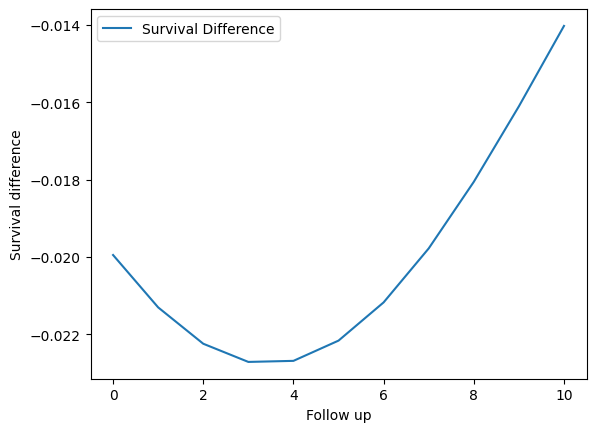

In [36]:
import matplotlib.pyplot as plt

def predict_survival(trial, trial_period=1, predict_times=range(11)):
    model = trial["outcome_model_fitted"]
    newdata = trial["loaded_data"][trial["loaded_data"]['trial_period'] == trial_period].copy()
    
    survival_0 = []
    survival_1 = []
    for t in predict_times:
        temp = newdata.copy()
        temp['followup_time'] = t
        temp['followup_time_sq'] = t ** 2
        temp['trial_period_sq'] = temp['trial_period'] ** 2
        
        temp_0 = temp.copy()
        temp_0['assigned_treatment'] = 0
        prob_0 = model.predict(temp_0)
        survival_0.append(1 - prob_0.mean())
        
        temp_1 = temp.copy()
        temp_1['assigned_treatment'] = 1
        prob_1 = model.predict(temp_1)
        survival_1.append(1 - prob_1.mean())
    
    survival_diff = np.array(survival_1) - np.array(survival_0)
    
    # Plot
    plt.plot(predict_times, survival_diff, label="Survival Difference")
    plt.xlabel("Follow up")
    plt.ylabel("Survival difference")
    plt.legend()
    plt.show()

predict_survival(trial_itt)